In [91]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [92]:
# reading the data into variable called name
import csv

names = []
with open('arabic_names.csv', 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        names.append(row[0])

names.pop(0)
print(f"The length of names is {len(names)}")
print(f"The first 5 names are {names[:5]}")

The length of names is 1405
The first 5 names are ['ابتسام', 'ابتهاج', 'ابتهال', 'اجتهاد', 'ازدهار']


In [93]:
# Randomizing the data set
random.seed(56)
random.shuffle(names)

n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))
print(f"the data set have {len(names)}, {n1=}, {n2=}")

the data set have 1405, n1=1124, n2=1264


In [94]:
# converting characters to number
chars = sorted(list(set(''.join(names))))
chars.insert(0, '.')

# create character to integer
ctoi = {value: index for index, value in enumerate(chars)}

# create integer to character
itoc = {value: index for index, value in ctoi.items()}

In [95]:
ctoi

{'.': 0,
 ' ': 1,
 'ء': 2,
 'آ': 3,
 'أ': 4,
 'ؤ': 5,
 'إ': 6,
 'ئ': 7,
 'ا': 8,
 'ب': 9,
 'ة': 10,
 'ت': 11,
 'ث': 12,
 'ج': 13,
 'ح': 14,
 'خ': 15,
 'د': 16,
 'ذ': 17,
 'ر': 18,
 'ز': 19,
 'س': 20,
 'ش': 21,
 'ص': 22,
 'ض': 23,
 'ط': 24,
 'ظ': 25,
 'ع': 26,
 'غ': 27,
 'ف': 28,
 'ق': 29,
 'ك': 30,
 'ل': 31,
 'م': 32,
 'ن': 33,
 'ه': 34,
 'و': 35,
 'ى': 36,
 'ي': 37}

In [96]:
# preparing the dataset and split them into training, dev, and test samples.
# we need the first one to be ., ., . --> ا

# define a function build_dataset to accept list of names and output them in X, Y format
block_size = 3
def build_dataset(names):
    X, Y = [], []
    for name in names:
        context = [0] * block_size

        for cha in name + '.':
            X.append(context)
            ix = ctoi[cha]
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [97]:
Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtest , Ytest = build_dataset(names[n2:])

In [98]:
print(f"{Xtr.shape=} {Ytr.shape=}, and {Xdev.shape=}, and {Xtest.shape=}")

Xtr.shape=torch.Size([6135, 3]) Ytr.shape=torch.Size([6135]), and Xdev.shape=torch.Size([750, 3]), and Xtest.shape=torch.Size([761, 3])


In [109]:
# define a gnerator
g = torch.Generator().manual_seed(123456789)

n_emb = 10  # The dimentions of the embedding space
n_hidden = 200 # number of neurones in the hidden layer
voc_len = len(chars)    # == 38

# creating the embedded layer to embed our 38 character in 2D arrya and the first layer
C = torch.randn((voc_len, n_emb),                   generator=g)
# Creating the hidden layer

# initialize the weight with kamminti
W1 = torch.randn((n_emb * block_size, n_hidden),    generator=g) * (5/3) /(n_emb * block_size) ** 0.5  #0.2
# b1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, voc_len),               generator=g) * 0.01
b2 = torch.randn(voc_len,                           generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones(1, n_hidden)


parameters = [C, W1, W2, b1, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

14618


In [114]:
# training process
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # making mini-patches
    random_numbers = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[random_numbers], Ytr[random_numbers]

    # forward pass
    emb = C[Xb]  # we're impeding the char in 2D array =>
    # print(f"The embed shape is {emb.shape=}") # (number of rows in X, number of columns in X, the crosponding vector from C to this number)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + # b1

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)

    hpreact = bngain * (hpreact - bnmeani) /  bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    h = torch.tanh(hpreact)
    # print(f"The hidden layer shape is {h.shape=}")
    logits = h @ W2 + b2
    # print(f"The Logits layer shape is {logits.shape=}, and Y shape is {Ysmall.shape=}")
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()


    # update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data += - lr * p.grad

    # track status
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

print(loss)

      0/ 200000: 1.9848
  10000/ 200000: 2.1377
  20000/ 200000: 1.5439
  30000/ 200000: 1.7550
  40000/ 200000: 1.6742
  50000/ 200000: 1.7153
  60000/ 200000: 1.4590
  70000/ 200000: 1.4314
  80000/ 200000: 1.1576
  90000/ 200000: 1.5842
 100000/ 200000: 1.9078
 110000/ 200000: 1.6395
 120000/ 200000: 1.4130
 130000/ 200000: 1.8828
 140000/ 200000: 1.2886
 150000/ 200000: 1.4942
 160000/ 200000: 1.5945
 170000/ 200000: 1.4441
 180000/ 200000: 1.7879
 190000/ 200000: 1.4652
tensor(1.5815, grad_fn=<NllLossBackward0>)


In [ ]:
plt.plot(lossi)

In [115]:
# Calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1

    # measure the man/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)


In [116]:
bnmean

tensor([[-0.8088,  0.3606,  0.2423,  0.8705,  1.4932, -0.3241, -1.7131, -0.6122,
         -0.1177,  0.2688,  0.7464, -0.2906, -0.0261, -0.4283,  0.2568,  0.7016,
         -0.1378, -0.6550, -0.0222,  0.4779,  0.2500, -0.5505,  0.4323, -0.4158,
          0.0883, -0.6375,  0.4146, -0.2603, -0.7694, -0.0385, -1.0814,  0.2354,
          1.0280,  0.1054,  0.3664, -0.0920,  0.9036,  0.8335,  0.9653, -0.1379,
         -0.9304, -0.8798, -0.8491, -1.3261, -0.0350, -0.5060, -0.4375,  0.1636,
          0.1412, -1.3199, -0.2449, -0.3646,  0.1068, -0.1563, -0.0606, -0.1752,
          0.6040, -0.1387, -0.0613, -0.5438, -0.6903, -0.3567, -1.3418,  0.9358,
          0.2270, -0.4911,  0.3384, -0.6328,  0.0559, -0.8822, -0.6012, -0.8275,
         -0.9208,  0.9646, -0.2727, -1.0240, -0.5102, -1.5008, -0.0291, -0.0966,
          0.9296, -0.1800, -0.1752,  0.0674,  0.2813, -0.1358,  0.1843,  0.0457,
          0.0258,  0.0480,  0.4904,  0.9750,  1.0556, -0.7567,  0.5691, -0.0753,
         -0.1398,  0.1462, -

In [117]:
bnmean_running

tensor([[-0.8178,  0.3626,  0.2516,  0.8717,  1.4876, -0.3186, -1.7024, -0.6108,
         -0.1071,  0.2798,  0.7467, -0.2818, -0.0201, -0.4291,  0.2686,  0.7082,
         -0.1227, -0.6329, -0.0389,  0.4893,  0.2624, -0.5344,  0.4221, -0.4184,
          0.0731, -0.6290,  0.4368, -0.2701, -0.7726, -0.0468, -1.0841,  0.2352,
          1.0112,  0.1154,  0.3595, -0.0853,  0.9191,  0.8399,  0.9538, -0.1284,
         -0.9331, -0.8633, -0.8467, -1.3264, -0.0368, -0.5048, -0.4614,  0.1755,
          0.1517, -1.3301, -0.2585, -0.3664,  0.1017, -0.1569, -0.0676, -0.1630,
          0.5997, -0.1649, -0.0739, -0.5510, -0.6952, -0.3451, -1.3488,  0.9248,
          0.2167, -0.4862,  0.3389, -0.6416,  0.0464, -0.8770, -0.6056, -0.8389,
         -0.9228,  0.9530, -0.2769, -1.0164, -0.5066, -1.5046, -0.0156, -0.0744,
          0.9282, -0.1575, -0.1901,  0.0784,  0.2876, -0.1303,  0.1905,  0.0377,
          0.0307,  0.0358,  0.4915,  0.9607,  1.0599, -0.7614,  0.5748, -0.0665,
         -0.1403,  0.1593, -

In [118]:
# calculate the loss in the entire dataset
@torch.no_grad()
def split_test(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'text': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_test('train')
split_test('val')

train 2.3819961547851562
val 3.3817925453186035


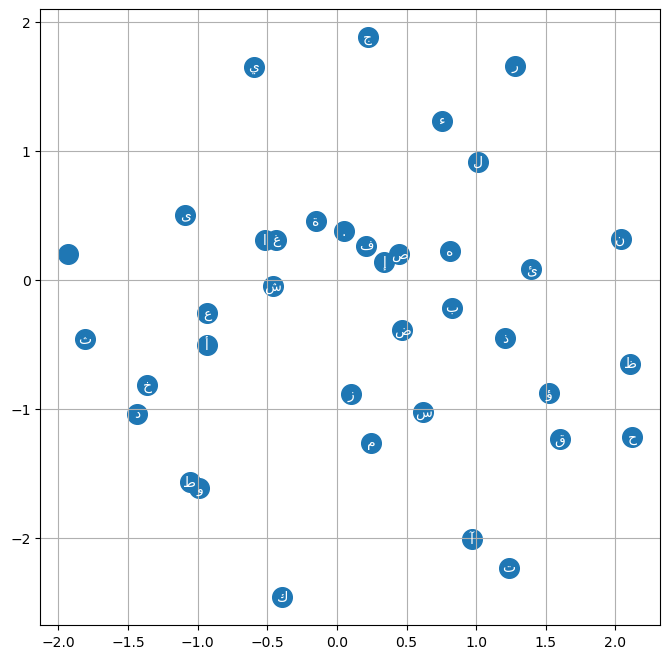

In [120]:
 # visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

In [119]:
# ٍSampling from the model
for _ in range(10):
    block_size = 3
    context = [0] * block_size
    out = []

    while True:
        emb = C[context]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        out.append(ix)
        context = context[1:] + [ix]
        if ix == 0:
            break;

    print("".join(itoc[i] for i in out))

كاثكرسهرف.
أغمرةطينة.
عميدرمجائب.
زعرغامتثن.
حائس.
عبداء.
عقثاء.
عميد.
جناء.
إيسزآةدلهان.


In [ ]:
context = [0] * block_size
C[context].shape

In [ ]:
torch.tensor(10).log()